#### This notebook aims to find threshold dt. 

In [18]:
import numpy as np
import scipy
import scipy.optimize
from scipy.optimize import curve_fit
from scipy import stats
import scipy.stats
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.colors as mcolors
from mpl_toolkits import mplot3d
import glob
import time
import pandas as pd
import math
#import File_functions
plt.rcParams["figure.figsize"] = (3,3)
print (time.ctime())

Sun Nov 21 23:48:24 2021


In [106]:
def One(x,y,file,plot,afterpulse_control = True):
    
    One.filename = file
    x1,y1=x,y

    old_data_table = pd.read_csv(f'{filename}')
    old_data_table = old_data_table.drop(columns = 'Unnamed: 0')
    old_data_table['time'] = ((25*old_data_table['time'])/(4096)) #Output in ns
    
    R = 2
    R1 = R
    Ion_1 = (
        old_data_table.query(f"((x-{x1})**2 + (y-{y1})**2)**(1/2) <= {R1}")
        .reset_index(drop=True)
    )
    name = Ion_1
    dt = []
    for i in range(0, len(name)-1):
        dt.append(name.at[i+1, 'time'] - name.at[i, 'time'])
    dt.insert(0,0)
    Ion_1['dt'] = dt
    
    if afterpulse_control:
        Ion_1.query(f' dt > 1e-7', inplace = True) # eliminate after pulsing effects, this prevents breaks in dark states, and peaks at 0(s) bright states
        Ion_1.reset_index(inplace = True)
    Ion_1['index'] = np.arange(len(name))
    
    
    One.data_table = Ion_1
    data_table= Ion_1
    One.ion_1=Ion(1, x, y, R, Ion_1, debugPrinting=False)
     
    if plot==True:
        fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (10, 4))
        ax1.hist2d(old_data_table['x'], old_data_table['y'], range = [(min(data_table['x'])-2, max(data_table['x'])+2), (min(data_table['y'])-2, max(data_table['y'])+2)], bins = (int(max(data_table['x']) - min(data_table['x']) +5) , int(max(data_table['y']) - min(data_table['y']) +5)))

        ax2.hist2d(data_table['x'], data_table['y'], range = [(min(data_table['x'])-2, max(data_table['x'])+2), (min(data_table['y'])-2, max(data_table['y'])+2)], bins = (int(max(data_table['x']) - min(data_table['x']) +5) , int(max(data_table['y']) - min(data_table['y']) +5)))

        plt.show()

In [20]:
def expon(x, rate, multiplier):   # in scipy.stats.expon() the paramater 
                                      #'scale = 1 / rate' when inputing the function
        return multiplier * np.exp(-rate * x)
class Ion:
    def __init__(self, n, x, y, r0, data, debugPrinting=False):
        self.filename=One.filename
        self.n = n # Ion number (left to right)
        self.x = x # x-position
        self.y = y # y-position
        self.r0 = r0 # radius
 
        self.data = data # Dataframe used (data_table in choose_file)
        
        
        self.threshold = [] # differentiator between bright/dark states by 'dt' between events in ROI
        
        self.bright = [] # stores data for only bright events
        self.dark = [] # stores data for only dark events
        
        self.transpts = []  # Transition points (index number)
        # DtB = dark to bright
        # BtD = bright to dark
        self.tofBright=[]
        self.tofDark=[]
        self.dtDark=[]
        self.dtBright=[]
        self.DtB = []
        self.BtD = []
        self.brightRanges = []
 
    def auto_threshold(self,sigma, uncertainty_control ): 
                
            
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (11, 3))
                bin_heights, bin_borders, _ = ax1.hist(self.data['dt'], bins = 'auto', range = (0, .05), alpha = .5, label='\'dt\' pdf', density = True)
                bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
                popt, pcov = curve_fit(expon, bin_centers, bin_heights, p0=[1/5e-4, bin_heights.max()])
                
                # fits the histogram to exponential. Input parameters for a specific data set but they seem to be pretty applicable to all datasets. 

                x_interval_for_fit = np.linspace(bin_centers[0], bin_centers[-1], 10000)       # define x values for fit
                ax1.plot(x_interval_for_fit, expon(x_interval_for_fit, *popt), label='fit')    # plot exponential fit on top of histogram
                ax1.set_yscale('log')      
                 # Display parameters 
                ax1.set_title(f'{filename} Ion #{self.n}')
                ax1.set_ylabel(f'Probability (log-base)');
                ax1.set_xlabel(f'Time between events in ROI (s)')

                # This part determines the theshold for the Bright/Dark state detection. Unless specified, the value 
                # will be set at the 2 sigma location based on fit params
                sigma_percent = stats.norm.cdf(sigma)                                                                # determine how much of the data should be used. %
                loc = 0; rate = popt[0] ; 
                
                int_to = stats.expon.ppf((sigma_percent), loc=loc, scale= 1 / rate)        # turns percent into a number (threshold value)
                print (int_to)
                #int_to=th
                
                self.upper_limit = stats.expon.ppf((sigma_percent), loc=loc, scale= 1 / (rate-(pcov[0][0]**2)))
                self.lower_limit = stats.expon.ppf((sigma_percent), loc=loc, scale= 1 / (rate+(pcov[0][0]**2)))

            #print (rate,"rate"),;print (pcov[0][0]**2,"sqrt"),; print ((rate-(pcov[0][0]**2)),"rate upper") 

                d = stats.expon.rvs(loc = loc, scale = rate, size = 10000)                                          # create random variables that follow the fit (for plotting)
                base = np.linspace(0,int_to,100000)
                ax1.plot(base,stats.expon.pdf(base,loc = loc, scale = 1 / rate), 'r', linewidth = 2,alpha = 0.4)     
                int_base1 = np.linspace(0,int_to,10000)                                                      #(below) plot a shaded region that displays the bright state values
                ax1.fill_between(int_base1, stats.expon.pdf(int_base1,loc = loc, scale = 1 / rate), color = 'b', linewidth = 0, alpha = .3, label = 'Bright')
                ax1.set_xlim(0, 2*int_to)
                ax1.legend()

                if uncertainty_control:
                    ax1.axvline(self.lower_limit)
                    ax1.axvline(self.upper_limit)


                #Print statements that tell you about the threshold and the fit parameters etc. 
                prob = 1 - stats.expon.cdf(int_to, loc=loc, scale= 1 / rate)
                z = (stats.norm.ppf(1-(prob)))
                #print(f'Ion {self.n} threshold: {int_to:.2e}(s)' )
                #print(f'Fit Parameters: [rate (lambda) = {popt[0]:.3e}] || [multiplier = {popt[1]:.3e}] \n')

                #Plot everything on a non-log base y-scale. 
                ax2.hist(self.data['dt'], bins = 'auto', range = (0, .05), alpha = .5, label='\'dt\' pdf', density = True)
                ax2.plot(x_interval_for_fit, expon(x_interval_for_fit, *popt), label='fit')
                ax2.set_title(f'{filename} Ion #{self.n}')
                ax2.set_ylabel(f'Probability')
                ax2.set_xlabel(f'Time between events in ROI (s)')
                ax2.plot(base,stats.expon.pdf(base,loc = loc, scale = 1 / rate), 'r', linewidth = 2,alpha = 0.4)
                ax2.fill_between(int_base1, stats.expon.pdf(int_base1,loc = loc, scale = 1 / rate), color = 'b', linewidth = 0, alpha = .3, label = 'Bright')
                ax2.set_ylim(0,bin_heights.max()*1.05)
                ax2.set_xlim(0, 2*int_to)
                ax2.legend()
                fig.tight_layout()

                self.threshold = int_to
                #print(self.threshold)
            
    def sortbythreshold(self, uncertainty_control = True):
        
        
        if uncertainty_control:
            # simple sorting method which sorts data based on the length of pause between events
            self.bright = self.data.query(f'dt < {self.lower_limit}')
            self.dark = self.data.query(f'dt > {self.upper_limit}')
            self.uncertain_state = self.data.query(f'{self.lower_limit} <= dt <= {self.upper_limit}')
        
            for i in self.uncertain_state['index']:
                if i-1 in self.bright['index'] and i+1 in self.bright['index']:
                    self.bright = self.bright.append(self.uncertain_state.loc[[i]])
                elif i-1 in self.dark['index'] and i+1 in self.dark['index']:
                    self.dark = self.dark.append(self.uncertain_state.loc[[i]])
                elif i-1 in self.bright['index'] and i+1 in self.dark['index']:
                    self.bright = self.bright.append(self.uncertain_state.loc[[i]])
                elif i-1 in self.dark['index'] and i+1 in self.bright['index']:
                    self.dark = self.dark.append(self.uncertain_state.loc[[i]])
                elif i-1 in self.bright['index']:
                    self.bright = self.bright.append(self.uncertain_state.loc[[i]])
                else:
                    self.dark = self.dark.append(self.uncertain_state.loc[[i]])
                
            self.bright = self.bright.sort_values('time')
            self.dark = self.dark.sort_values('time')
        
        else: 
            self.bright = self.data.query(f'dt < {self.threshold}')
            self.dark = self.data.query(f'dt > {self.threshold}')

            
        #print(f'Bright events (#/%): {len(self.bright)} / {len(self.bright)/len(self.data)*100:.2f}% \n')
        b_or_d = []
        for i in self.data['index']:
            if self.data.at[i, 'dt'] <= self.threshold:
                b_or_d.append(1)
            else:
                b_or_d.append(-1)
        self.data['B/D'] = b_or_d
        
        
        ### plots histogram of 'dt' values separately for Bright/Dark states ### (upperbound made to eliminate regions of extremely long dark states)
    
        ### Locate and save the locations that BtD and DtB transitions occur ###
    def transitions(self, single_photon_control = True):
       
        # identifies points where quantum jumps happen
        # using list comprehension
        misscount = 0
        self.transpts.clear()
        for i in range(len(self.data)) :
            if i not in self.bright['index']:
                misscount = misscount + 1
                if misscount == 1:
                    self.transpts.append(i)
            if i in self.bright['index'] and misscount >= 1:
                misscount = 0
                self.transpts.append(i)
        
        
                
        # DtB = dark to bright
        # BtD = bright to dark
        self.DtB.clear()
        self.BtD.clear()
        for i in range(len(self.transpts)):
            if self.transpts[i] in self.bright['index']:
                self.DtB.append(self.transpts[i])
            else:
                self.BtD.append(self.transpts[i])
                
        ### This functions finds the time between the events ('points') before a BtD transition,
        #  averages each 'point' and plots what can be referred to as an 'average transition' ###
        
    
    
    def setup(self,kind,sigma, uncertainty_control, single_photon_control):
        
        if kind=="auto":
            
            self.auto_threshold(sigma,uncertainty_control)
            self.sortbythreshold(uncertainty_control)
            self.transitions(single_photon_control)
        elif kind=="integration":
            self.FindBrightRangesPrecise(arrT,N)

#--------------------------------------------
#PDFs
#-----
    

    def Lorentzian(x, x0, a, gam, b):
        return b + a * gam**2 / ( gam**2 + ( x - x0 )**2)

    def Double_Lorentzian(x, x1, a1, gam1, b1, x2, a2, gam2):
        return b1 + a1 * gam1**2 / ( gam1**2 + ( x - x1 )**2) + a2 * gam2**2 / ( gam2**2 + ( x - x2 )**2)

    def Linear(x, m, b):
        return m*x + b

    def Oscillation(x, A, B, phase):
        return A + np.abs(B) *np.sin(2*np.pi*(x)/54.789717 + phase)

    def Gaussian(x, xm, sigma, A, c):
        return np.absolute(A)*np.exp(-np.power((x-xm)/sigma,2)/2) + c
               

Beam Position: 389.5 <br>
Ion Position : x=47

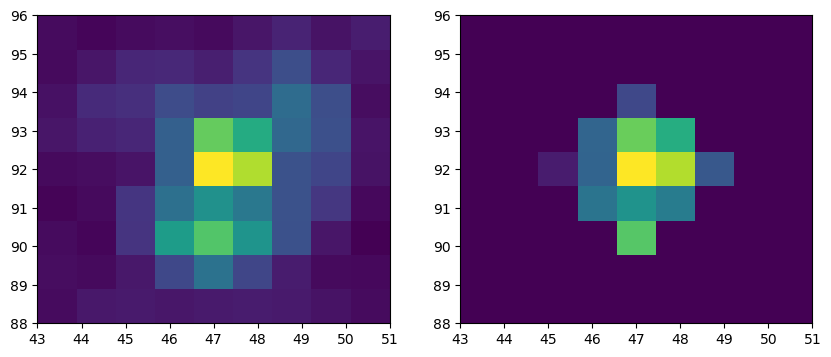

In [71]:
filename='P/x_389.5'
One(x=47,y=92,file=filename) # x=47; y=92 (Actual Ion)

In [72]:
ion_1=One.ion_1 #ROI of ion centered at x=47

In [73]:
ion_data_table=One.data_table 

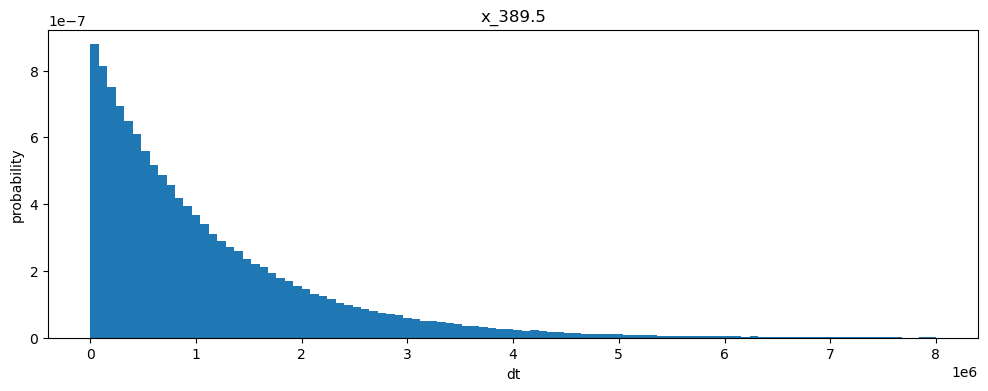

In [24]:
fig,ax=plt.subplots(figsize=(12,4))
plt.hist(ion_data_table["dt"],range=(0,8e6),bins=100,density=True)
plt.xlabel("dt")
plt.ylabel("probability")
plt.title(f'{filename[2:]}')
plt.show()

dt (ns) of Ion. 

<b> Rolling Mean:  </b> Creates a series of averages. Basically, reduces fluctuations in data and helps visualize overall trend. <br>
Example: (Plot unrelated to the expeiment; only for reference)
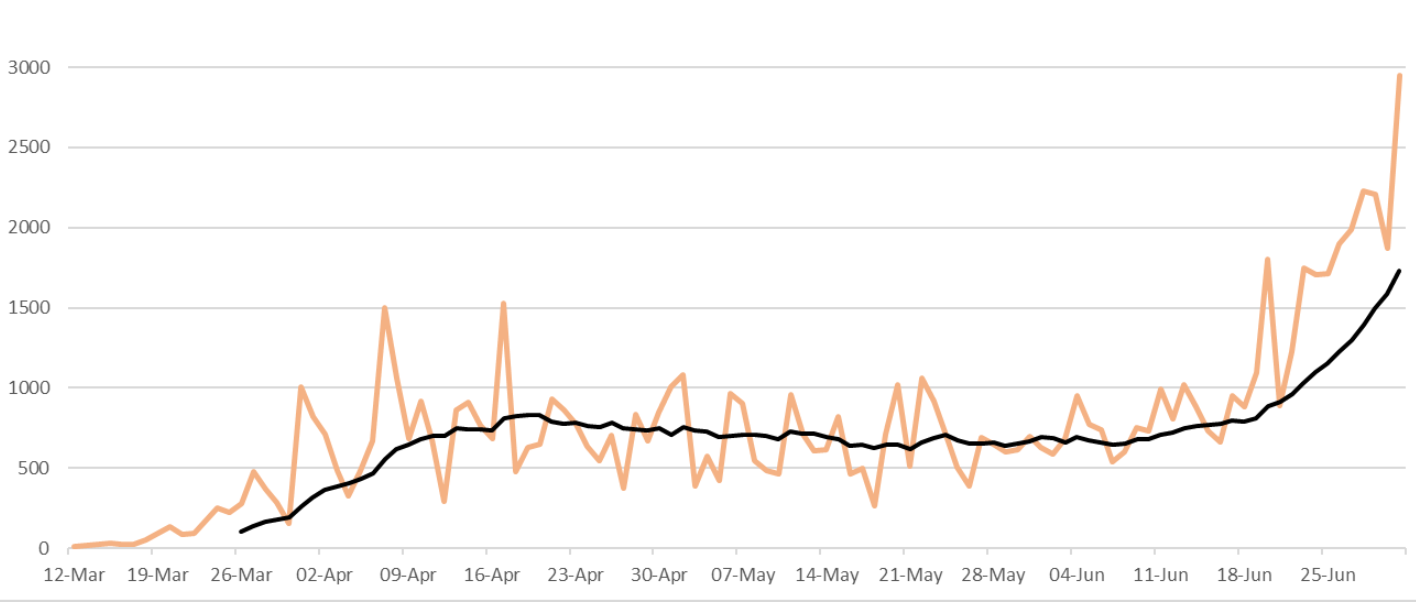

In [29]:
window=3 # take average of this number of observations 
rolling_windows=ion_data_table.rolling(window) #divides dataframe into windows of given size 
Count_mean_ion=rolling_windows.mean() # outputs average of each window 
Count_mean_ion=Count_mean_ion[window:] #removes NaN values

window=2 # take average of this number of observations 
rolling_windows_2=ion_data_table.rolling(window) #divides dataframe into windows of given size 
Count_mean_ion_2=rolling_windows.mean() # outputs average of each window 
Count_mean_ion_2=Count_mean_ion_2[window:] #removes NaN values

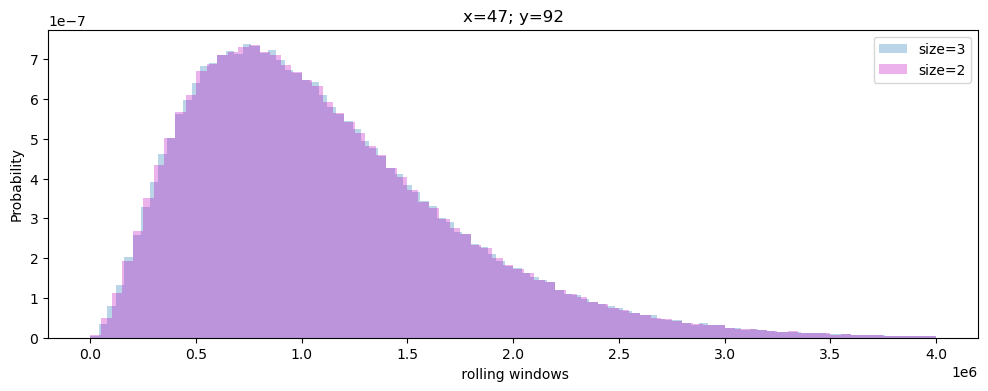

In [49]:
fig,ax=plt.subplots(figsize=(12,4))
ax.hist(Count_mean_ion["dt"],range=(0,4e6),bins=100,density=True,alpha=0.3,label="size=3")
ax.hist(Count_mean_ion_2["dt"],range=(0,4e6),bins=80,density=True,alpha=0.3,label="size=2",color="m")
ax.set_xlabel(f' rolling windows')
ax.legend()
ax.set_ylabel("Probability")
ax.set_title(f'x={ion_1.x}; y={ion_1.y}')
plt.show()

Exactly same distribution for window sizes 2 and 3.

### Checking Dark Regions

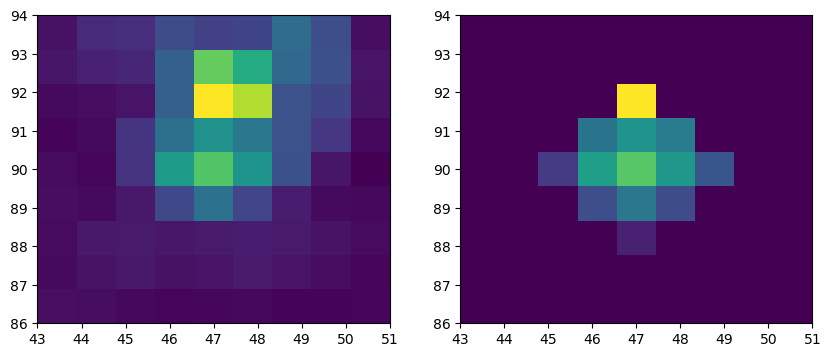

In [10]:
One(x=47,y=90,file=filename) # Region just below ion

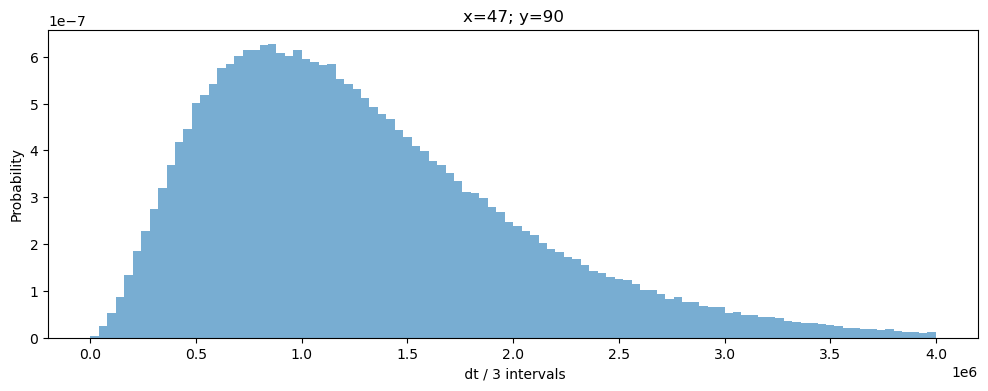

In [11]:
bottom_ion_1=One.ion_1
data_table=One.data_table

window=3
rolling_windows=data_table.rolling(window)
Count_mean_1=rolling_windows.mean()
Count_mean_1=Count_mean_1[window:]

plt.figure(figsize=(12,4))
plt.hist(Count_mean_1["dt"],range=(0,4e6),bins=100,density=True,alpha=0.6)
plt.xlabel(f' dt / {window} intervals')
plt.ylabel("Probability")
plt.title(f'x={One.ion_1.x}; y={One.ion_1.y}')
plt.show()

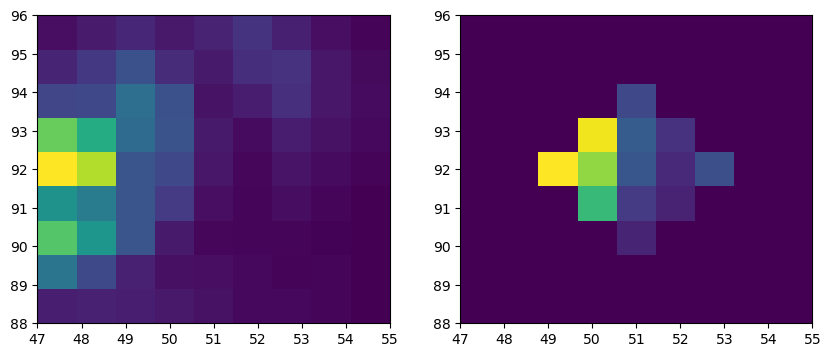

In [50]:
One(x=51,y=92,file=filename) #Region just right of the ion. 

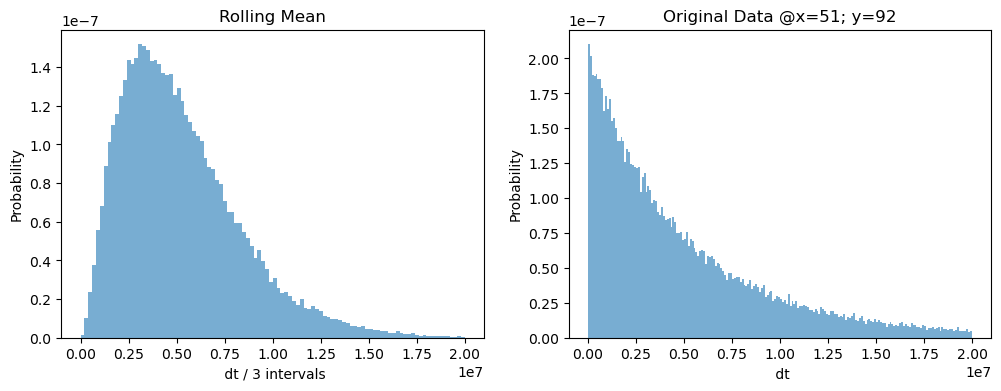

In [52]:
r_ion_1=One.ion_1
data_table=One.data_table

window=3
rolling_windows=data_table.rolling(window)
Count_mean_1=rolling_windows.mean()
Count_mean_1=Count_mean_1[window:]

fig,(ax,ax1)=plt.subplots(1,2,figsize=(12,4))
ax.hist(Count_mean_1["dt"],range=(0,2e7),bins=100,density=True,alpha=0.6)
ax.set_xlabel(f' dt / {window} intervals')
ax.set_ylabel("Probability")
ax.set_title(f'Rolling Mean')

ax1.hist(data_table["dt"],range=(0,2e7),bins=200,density=True,alpha=0.6)
ax1.set_xlabel(f' dt')
ax1.set_ylabel("Probability")
ax1.set_title(f'Original Data @x={One.ion_1.x}; y={One.ion_1.y}')
plt.show()

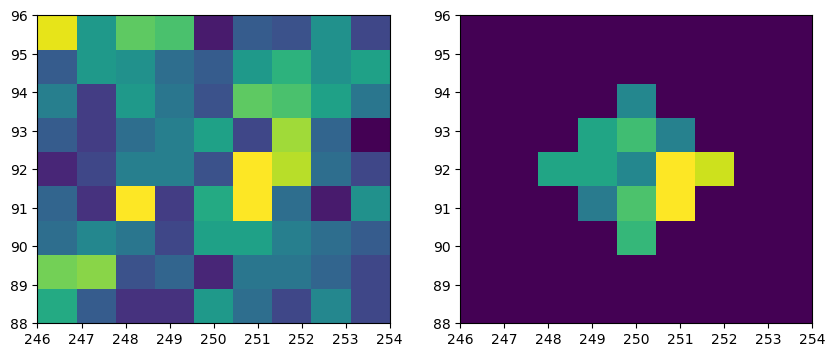

In [55]:
One(x=250,y=92,file=filename) # Plots region x=250

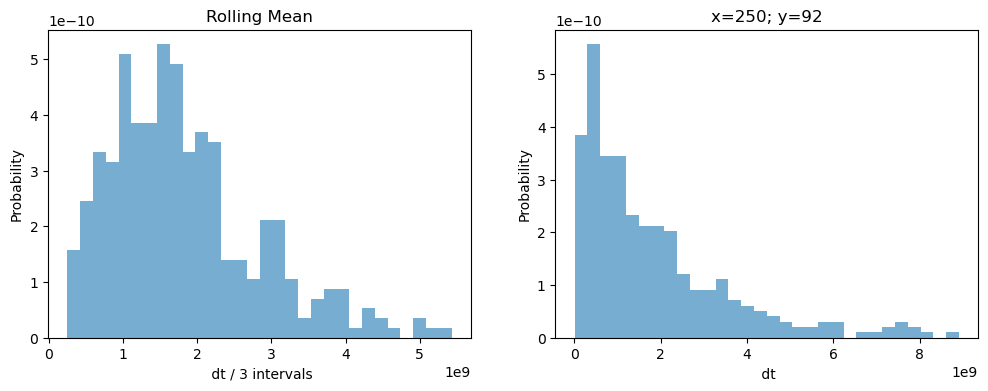

In [58]:
far_ion_1=One.ion_1
data_table=One.data_table

window=3
rolling_windows=data_table.rolling(window)
Count_mean_1=rolling_windows.mean()
Count_mean_1=Count_mean_1[window:]

fig,(ax,ax1)=plt.subplots(1,2,figsize=(12,4))
ax.hist(Count_mean_1["dt"],bins=30,density=True,alpha=0.6)
ax.set_xlabel(f' dt / {window} intervals')
ax.set_ylabel("Probability")
ax.set_title(f'Rolling Mean')

ax1.hist(data_table["dt"],bins=30,density=True,alpha=0.6)
ax1.set_xlabel(f' dt')
ax1.set_ylabel("Probability")
ax1.set_title(f'x={One.ion_1.x}; y={One.ion_1.y}')
plt.show()

In [16]:
len(np.unique((data_table["dt"].astype(int)))) #checking number of bins

333

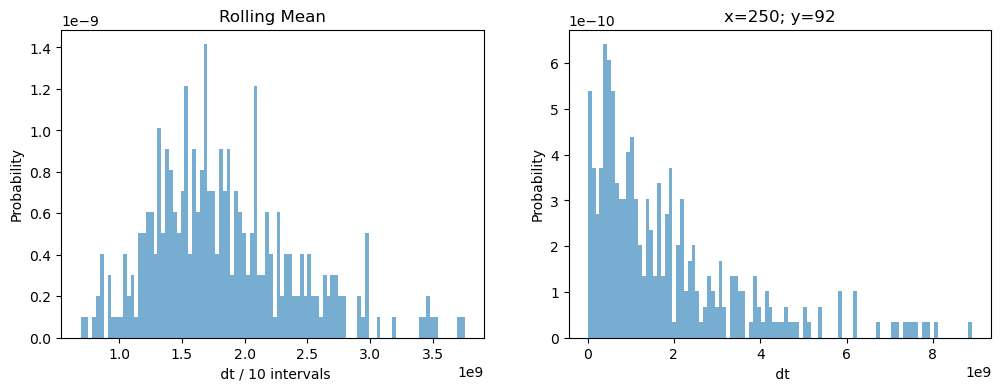

In [59]:
window=10
rolling_windows=data_table.rolling(window)
Count_mean_1=rolling_windows.mean()
Count_mean_1=Count_mean_1[window:]

fig,(ax,ax1)=plt.subplots(1,2,figsize=(12,4))
ax.hist(Count_mean_1["dt"],bins=100,density=True,alpha=0.6)
ax.set_xlabel(f' dt / {window} intervals')
ax.set_ylabel("Probability")
ax.set_title(f'Rolling Mean')

ax1.hist(data_table["dt"],bins=100,density=True,alpha=0.6)
ax1.set_xlabel(f' dt')
ax1.set_ylabel("Probability")
ax1.set_title(f'x={One.ion_1.x}; y={One.ion_1.y}')
plt.show()

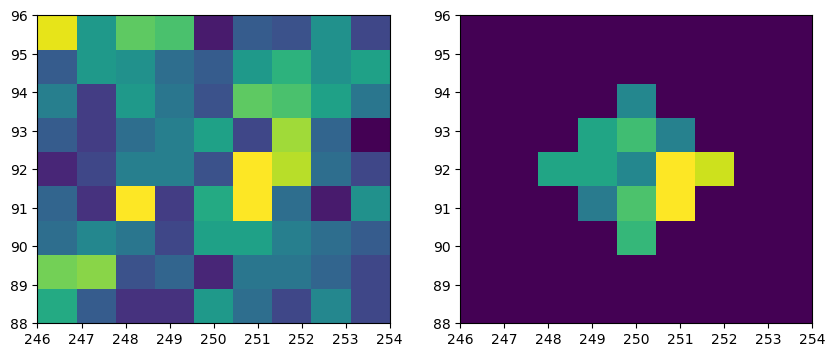

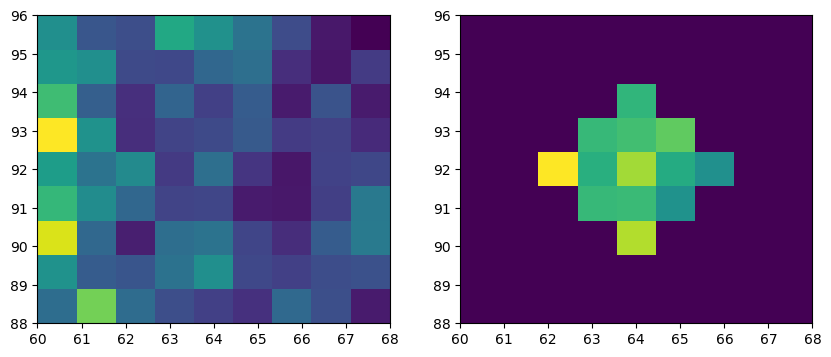

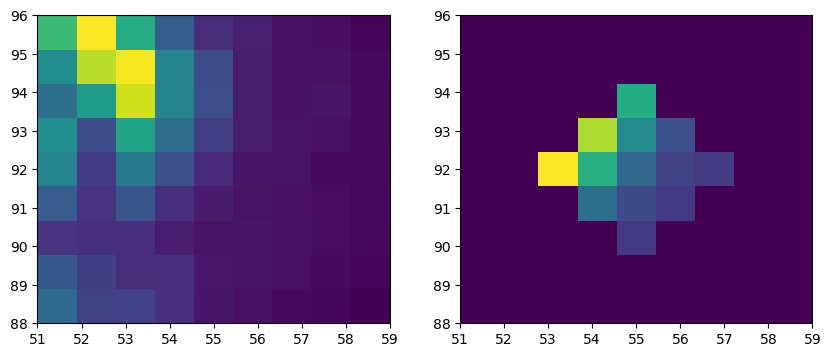

In [77]:
One(x=250,y=92,file=filename)
far=One.data_table
far_rolling_windows=far.rolling(window)
far_Count_mean_1=far_rolling_windows.mean()
far_Count_mean_1=far_Count_mean_1[window:]

One(x=64,y=92,file=filename)
mid2=One.data_table
mid2_rolling_windows=mid2.rolling(window)
mid2_Count_mean_1=mid2_rolling_windows.mean()
mid2_Count_mean_1=mid2_Count_mean_1[window:]

One(x=55,y=92,file=filename)
mid1=One.data_table
mid1_rolling_windows=mid1.rolling(window)
mid1_Count_mean_1=mid1_rolling_windows.mean()
mid1_Count_mean_1=mid1_Count_mean_1[window:]

In [ ]:
One(x=55,y=92,file=filename)
mid1=One.data_table
mid1_rolling_windows=mid1.rolling(window)
mid1_Count_mean_1=mid1_rolling_windows.mean()
mid1_Count_mean_1=mid1_Count_mean_1[window:]

In [12]:
import matplotlib.animation as animation

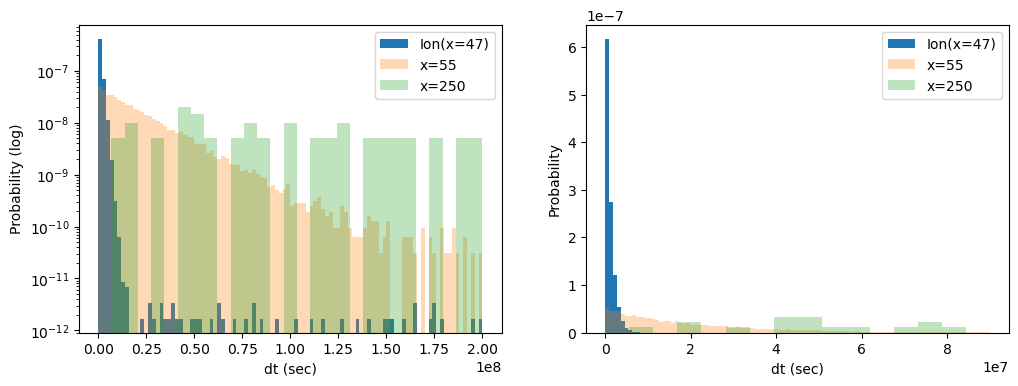

In [99]:
fig,(ax1,ax)=plt.subplots(1,2,figsize=(12,4))
a1,b1,p=ax.hist(ion_data_table["dt"],bins=100,range=(0,9e7),density=True,label="Ion(x=47)")
a4,b4,p=ax.hist(mid1["dt"],bins=100,range=(0,9e7),density=True,alpha=0.3,label="x=55")
a2,b2,p=ax.hist(far["dt"],bins=16,range=(0,9e7),density=True,alpha=0.3,label="x=250")

ax.legend()
ax.set_xlabel("dt (sec)")
ax.set_ylabel("Probability")
#ax.set_yscale("log")

a1,b1,p=ax1.hist(ion_data_table["dt"],bins=100,range=(0,2e8),density=True,label="Ion(x=47)")
a4,b4,p=ax1.hist(mid1["dt"],bins=100,range=(0,2e8),density=True,alpha=0.3,label="x=55")
a2,b2,p=ax1.hist(far["dt"],bins=29,range=(0,2e8),density=True,alpha=0.3,label="x=250")

ax1.legend()
ax1.set_xlabel("dt (sec)")
ax1.set_ylabel("Probability (log)")
ax1.set_yscale("log")
plt.show()

In [104]:
#hits in dark region
b=far.query(f'dt<9e7')
len(b)

16

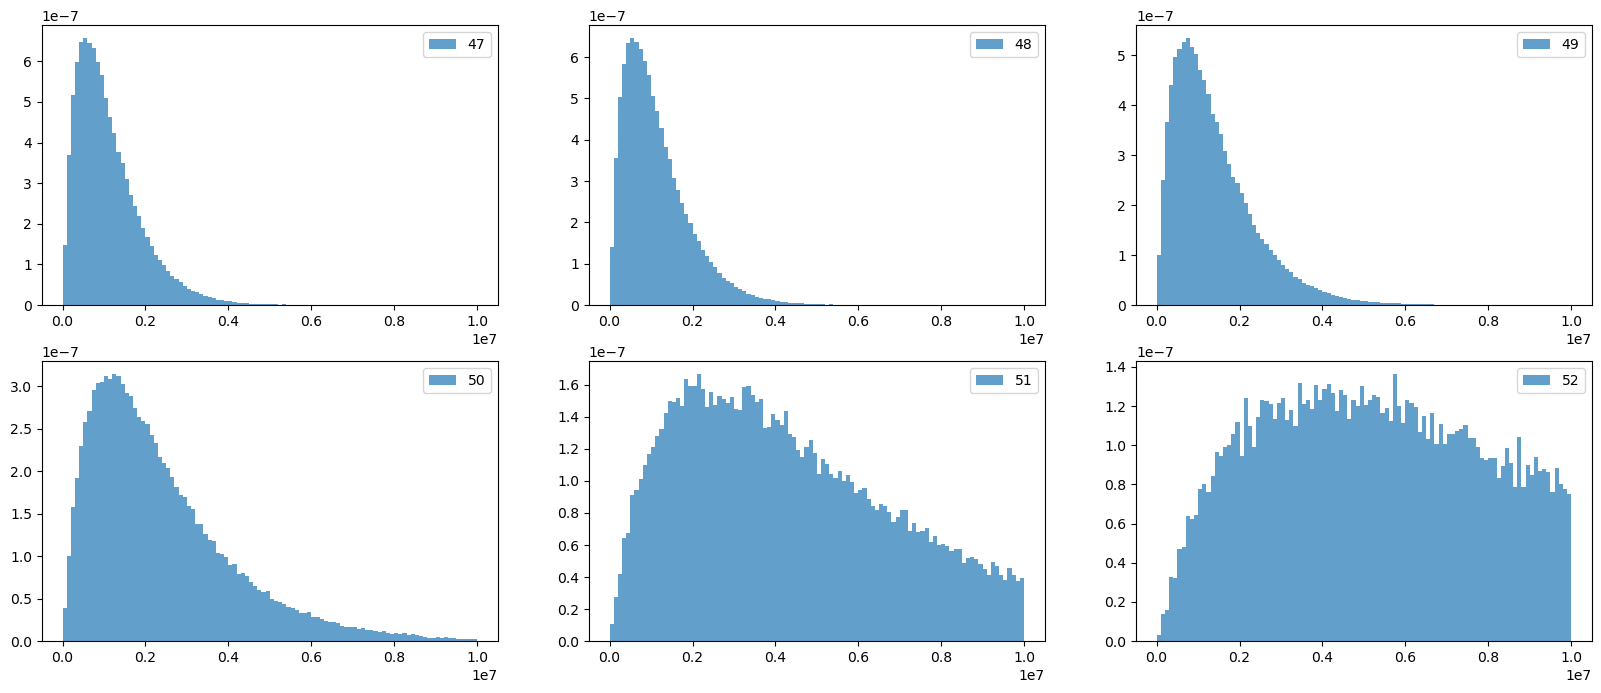

In [116]:
#axes=[ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10]
#fig,(ax1,ax2,ax3,ax4,ax5),(ax6,ax7,ax8,ax9,ax10)=plt.subplots(2,5,figsize=(20,8))

fig,axes=plt.subplots(2,3,figsize=(20,8))
def roller(data,window):
    mid=One.data_table
    mid_rolling_windows=mid.rolling(window)
    mid_Count_mean=mid_rolling_windows.mean()
    mid_Count_mean=mid_Count_mean[window:]
    return mid_Count_mean
    

for i, ax in enumerate(axes.flat):
    middle=roller(One(x=(ion_1.x+i),y=92,file=filename,plot=False),window=2)
    ax.hist(middle["dt"],range=(0,1e7),bins=100,density=True,alpha=0.7,label=str(ion_1.x+i))
    ax.legend()

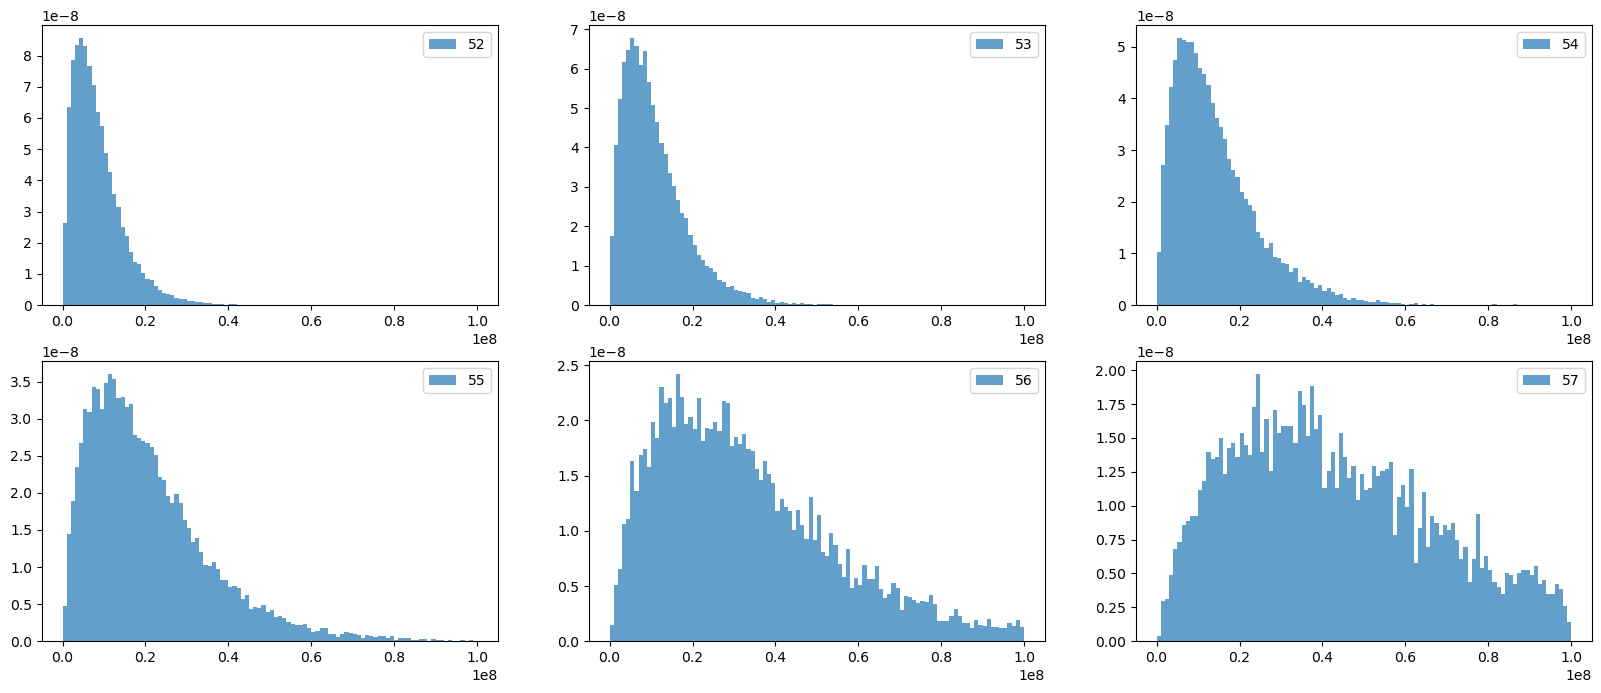

In [119]:
fig,axes=plt.subplots(2,3,figsize=(20,8))
def roller(data,window):
    mid=One.data_table
    mid_rolling_windows=mid.rolling(window)
    mid_Count_mean=mid_rolling_windows.mean()
    mid_Count_mean=mid_Count_mean[window:]
    return mid_Count_mean
    

for i, ax in enumerate(axes.flat):
    middle=roller(One(x=(ion_1.x+5+i),y=92,file=filename,plot=False),window=2)
    ax.hist(middle["dt"],range=(0,1e8),bins=100,density=True,alpha=0.7,label=str(ion_1.x+5+i))
    ax.legend()

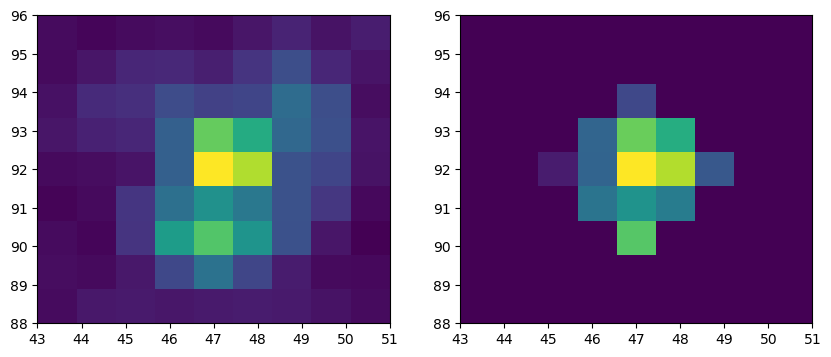

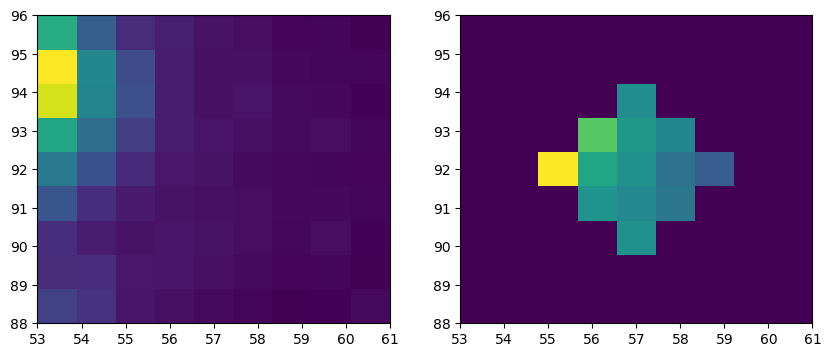

In [132]:
ion_1=roller(One(x=47,y=92,file=filename,plot=True),window=2) # Ion
ion_2=roller(One(x=57,y=92,file=filename,plot=True),window=2) # 2nd ion in 370 V file

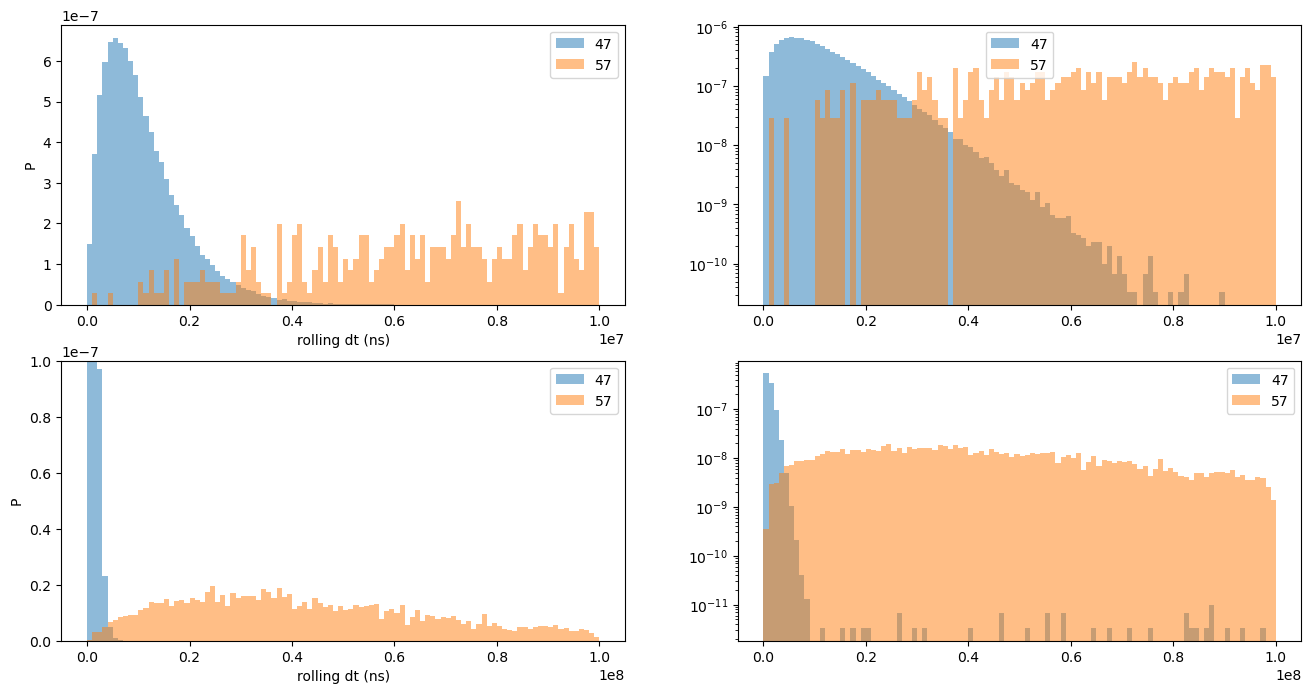

In [139]:
fig,ax=plt.subplots(2,2,figsize=(16,8))
ax.flat[0].hist(ion_1["dt"],range=(0,1e7),bins=100,density=True,alpha=0.5,label="47")
ax.flat[0].hist(ion_2["dt"],range=(0,1e7),bins=100,density=True,alpha=0.5,label="57")
ax.flat[0].legend()
ax.flat[0].set_xlabel("rolling dt (ns)")
ax.flat[0].set_ylabel("P")

ax.flat[1].hist(ion_1["dt"],range=(0,1e7),bins=100,density=True,alpha=0.5,label="47")
ax.flat[1].hist(ion_2["dt"],range=(0,1e7),bins=100,density=True,alpha=0.5,label="57")
ax.flat[1].legend()
ax.flat[1].set_yscale("log")

ax.flat[2].hist(ion_1["dt"],range=(0,1e8),bins=100,density=True,alpha=0.5,label="47")
ax.flat[2].hist(ion_2["dt"],range=(0,1e8),bins=100,density=True,alpha=0.5,label="57")
ax.flat[2].legend()
ax.flat[2].set_xlabel("rolling dt (ns)")
ax.flat[2].set_ylabel("P")
ax.flat[2].set_ylim(0,1e-7)

ax.flat[3].hist(ion_1["dt"],range=(0,1e8),bins=100,density=True,alpha=0.5,label="47")
ax.flat[3].hist(ion_2["dt"],range=(0,1e8),bins=100,density=True,alpha=0.5,label="57")
ax.flat[3].legend()
ax.flat[3].set_yscale("log")